In [3]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from math import log2, ceil

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleAverage, LinearRegressionDecider
from proglearn.transformers import TreeRegressionTransformer
from proglearn.voters import TreeRegressionVoter
from joblib import Parallel, delayed

In [59]:
def generateLinear(sample_size):
    # Create the Task A dataset
    X, y, coef = make_regression(n_samples=sample_size, n_features=1, n_informative=1, noise=0.05, coef=True, bias=0.0)

    # Use linear regression to find the true values
    regressor = LinearRegression()
    regressor.fit(X, y)

    # Rescale y = mx + b to be y* = x, where y* = (y - b) / m
    y = (y - regressor.intercept_) / regressor.coef_
    y = y.reshape(X.shape[0], -1)
    y += np.random.normal(size=y.shape, scale=0.1)

    return X, y

In [60]:
def plot_distributions(x, y, title):
    colors = sns.color_palette("Dark2", n_colors=2)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(x, y, s=50)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, fontsize=30)
    plt.tight_layout()
    ax.axis("off")
    plt.show()

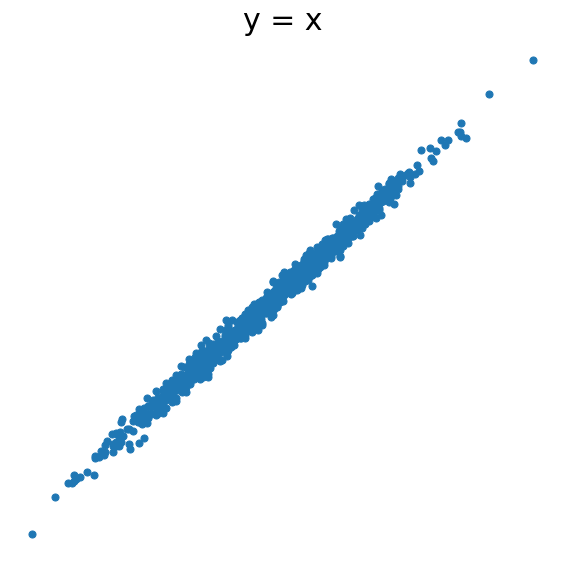

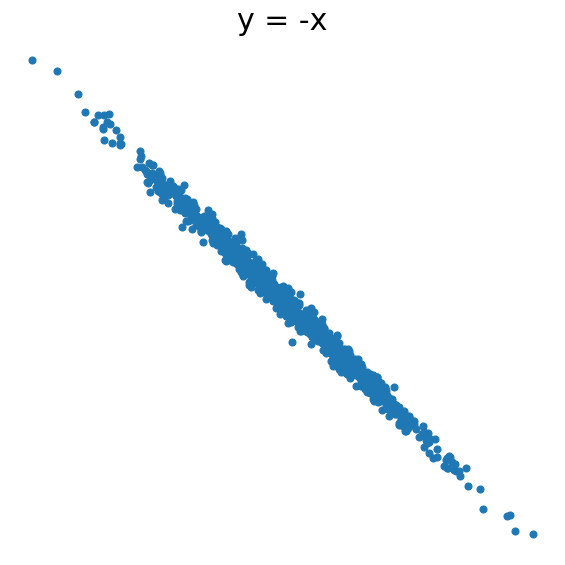

In [61]:
X, Y = generateLinear(1000)
Z, W = generateLinear(1000)
Z = -Z

# plot and format:
plot_distributions(X, Y, 'y = x')
plot_distributions(Z, W, 'y = -x')

In [62]:
def experiment(n_pos, n_neg, n_test, n_trees, max_depth, acorn=None):
    
    # See if the sample sizes for both training sets,
    # y=x and y=-x have been given.
    if n_pos == 0 and n_neg == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    # If acorn is specified, set random seed to it
    if acorn != None:
        np.random.seed(acorn)

    # Initialize array for storing errors, we need two errors,
    # one for task 1 (y=x) and one for task 2 (y=-x)
    errors = np.zeros(2, dtype=float)
    
    # Initialize the transformer type and arguments
    default_transformer_class = TreeRegressionTransformer
    default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}
    
    # Initialize the voter type and arguments
    default_voter_class = TreeRegressionVoter
    default_voter_kwargs = {}
    
    # Initialize the decider type and arguments
    default_decider_class = SimpleAverage
    default_decider_kwargs = {}
    
    # Initialize the progressive learner using the transformer, voter,
    # and decider classes
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                             default_transformer_kwargs = default_transformer_kwargs,
                                             default_voter_class = default_voter_class,
                                             default_voter_kwargs = default_voter_kwargs,
                                             default_decider_class = default_decider_class,
                                             default_decider_kwargs = default_decider_kwargs)
    
    # Create the datasets for the linear expressions and their test sets
    if (n_pos != 0):
        X, Y = generateLinear(n_pos)
        X_test, Y_test = generateLinear(n_test)
    if (n_neg != 0):
        Z, W = generateLinear(n_neg)
        Z = -Z
        Z_test, W_test = generateLinear(n_test)
        Z_test = -Z_test
    
    #####################################################################
    # Start training and predicting with the progressive learner
    #####################################################################
    # If there is no sample size for y=x, then only add a task for y=-x, predict
    # the probabilities and add the errors to the error array
    if (n_pos == 0 and n_neg != 0):
        # Add task to progressive learner
        progressive_learner.add_task(Z, W)
        predicted_W = progressive_learner.predict_proba(Z_test, task_id=0)

        errors[0] = 1.0
        errors[1] = mean_squared_error(predicted_W, W_test)
    
    # If there is no sample size for y=-x, then only add a task for y=x, predict
    # the probabilities and add the errors to the error array
    elif (n_neg == 0 and n_pos != 0):
        # Add task to progressive learner
        progressive_learner.add_task(X, Y)
        predicted_Y = progressive_learner.predict_proba(X_test, task_id=0)

        errors[0] = mean_squared_error(predicted_Y, Y_test)
        errors[1] = 1.0
    
    # If both sample sizes are given, add a task for the first dataset, predict
    # the probabilities and add the errors to the error array. Then, add the
    # transformer trained on y=-x and predict the error from there.
    elif (n_neg != 0 and n_pos != 0):
        # Add tasks to progressive learner
        progressive_learner.add_task(X, Y)
        predicted_Y = progressive_learner.predict_proba(X_test, task_id=0)
        errors[0] = mean_squared_error(predicted_Y, Y_test)
        
        progressive_learner.add_transformer(W, Z,
                                            transformer_class=default_transformer_class,
                                            transformer_kwargs=default_transformer_kwargs,
                                            voter_class=default_voter_class,
                                            voter_kwargs=default_voter_kwargs,
                                            transformer_id=1
                                           )
        predicted_transformer_Y = progressive_learner.predict_proba(Y_test, transformer_ids=[0,1], task_id=0)
        errors[1] = mean_squared_error(predicted_transformer_Y, Y_test)
        
    return errors

In [76]:
# Set up the tree parameters
mc_rep = 100
n_test = 1000
n_trees = 20
n_sample_size = 1000
max_depth = 15

# Sample sizes for y=x and y=-x
n_pos = (100*np.arange(0.5, 7.25, step=0.50)).astype(int)
n_neg = (100*np.arange(0.5, 7.50, step=0.50)).astype(int)

In [77]:
# Initiate error arrays
mean_error = np.zeros((2, len(n_pos) + len(n_neg)))
std_error = np.zeros((2, len(n_pos) + len(n_neg)))

# Initiate transfer efficiency arrays
mean_te = np.zeros((1, len(n_pos) + len(n_neg)))
std_te = np.zeros((1, len(n_pos) + len(n_neg)))

#####################################################################
# Iterate over the sample sizes.
#####################################################################
# Start with only task 1 (y=x) dataset and calculate the mean squared error 
# for only one task. Then, when we reach the end of the sample size for y=x,
# we use the maximum sample size for task 1 and see how BTE and FTE change 
# when we iterate over the sample size for task 2 (y=-x). 
for i, n1 in enumerate(n_pos):
    print('starting to compute y=x, sample size=%s\n' %n1)
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment)(
                n1, 0, n_test, n_trees, max_depth) for _ in range(mc_rep)
            )
        )
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0]/error[:,1])
    std_te[0,i] = np.std(error[:,0]/error[:,1],ddof=1)
    
    if n1==n_pos[-1]:
        for j,n2 in enumerate(n_neg):
            print('starting to compute y=-x, sample size=%s\n'%n2)
            error = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                    delayed(experiment)(n1,n2,n_test,n_trees,max_depth) for _ in range(mc_rep)
                )
            )
            # extract relevant data and store in arrays
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = np.mean(error[:,0]/error[:,1])
            std_te[0,i+j+1] = np.std(error[:,0]/error[:,1],ddof=1)

with open('./data/mean_setting1.pickle', 'wb') as f:
    pickle.dump(mean_error, f)
    
with open('./data/std_setting1', 'wb') as f:
    pickle.dump(std_error, f)

with open('./data/mean_te_setting1', 'wb') as f:
    pickle.dump(mean_te, f)

starting to compute y=x, sample size=50



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=100



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=150



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=200



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=250



[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=300



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=350



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=400



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=450



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=500



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=550



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=600



[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=650



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=700



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=50



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=100



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=150



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=200



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=250



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=300



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=350



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=400



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=450



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=500



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    4.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=550



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=600



[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=650



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=700



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.0s finished


No handles with labels found to put in legend.


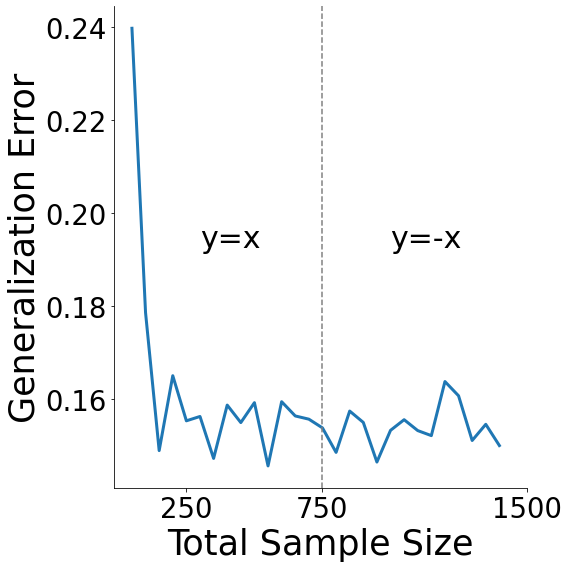

In [78]:
# define labels
TASK1 = "y=x"
TASK2 = "y=-x"

x_vals = np.concatenate((n_neg, n_pos + n_pos[-1]))
y1_vals = mean_error[0]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(x_vals, y1_vals, ls="-", lw=3)

ax1.set_ylabel("Generalization Error", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

No handles with labels found to put in legend.


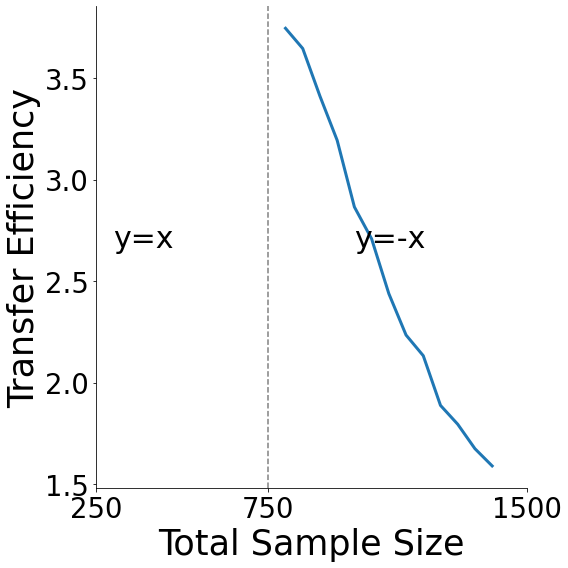

In [79]:
# define labels
TASK1 = "y=x"
TASK2 = "y=-x"

x_vals = np.concatenate((n_neg, n_pos + n_pos[-1]))
y1_vals = mean_te[0]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(x_vals[len(n_pos)+1:], y1_vals[len(n_pos)+1:], ls="-", lw=3)

ax1.set_ylabel("Transfer Efficiency", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()